# Full test ETNN configs determined by optuna

## Importing section

In [1]:
import os
import sys

from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from etnn.nn.baseline import create_baseline_model, calc_params
from etnn.tools.training import train_epoch, eval_epoch

sys.path.insert(0, os.path.pardir)

In [2]:
import pandas as pd
import torch

from etnn.routines.run_config import run_config, choice_optim, choice_loss, choice_trainloader, acquire_config_idx, \
    choice_dataset

import matplotlib.pyplot as plt

from etnn.tools.training_tools import ConfigStore, seeding_all, EpochControl, AccuracyManager

## Definitions section

In [3]:
def run_baseline_custom(
        model,
        config,
        device: str = "cuda" if torch.cuda.is_available() else 'cpu',
        dataset_path: str = "../../datasets"
):
    # definition of constants
    test_perc = 0.3

    # CHOICES FOR DATASET
    dataset, df_index = choice_dataset(config, dataset_path)

    # SPLITTING DATASET IN TRAIN AND VAL
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds = random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # ESTABLISHMENT OF LOADERS
    train_loader = choice_trainloader(config, df_index, train_ds)

    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # DEFINE LOSS AND OPTIMIZER
    criterion = choice_loss(config)

    # set seeds
    seeding_all(config.seed)

    # move model to device
    model = model.to(device)

    optimizer = choice_optim(config, model)

    # init storage containers
    train_loss = []
    test_loss = []
    train_r2 = []
    test_r2 = []

    # train for N epochs
    for _ in tqdm(range(config.num_max_epochs)):
        train_mean_loss, train_true_y, train_pred_y = train_epoch(
            model,
            train_loader,
            optimizer,
            device,
            criterion
        )

        test_mean_loss, test_true_y, test_pred_y = eval_epoch(
            model,
            test_loader,
            device,
            criterion
        )

        train_loss += [train_mean_loss.item()]
        test_loss += [test_mean_loss.item()]
        train_r2 += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
        test_r2 += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]

    # fuze dataset and save
    df = pd.DataFrame({
        "epoch": list(range(1, config.num_max_epochs + 1)),
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_r2": train_r2,
        "test_r2": test_r2
    })

    return df

In [4]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # plot train test and val
    for mode in ['train', 'test', 'val']:
        # plot training
        if f"{mode}_{what}" in df.columns:
            plt.plot(df.epoch, df[f"{mode}_{what}"], label=f"{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    elif what == "loss":
        plt.yscale('log')
    plt.legend()
    plt.show()

## Tree advanced label

Rank 1 parameter configuration: Unnamed: 0                                      26
number                                          26
value                                     0.935581
datetime_start          2023-12-07 19:48:17.592637
datetime_complete       2023-12-07 19:50:09.947736
duration                    0 days 00:01:52.355099
params_batcher                                True
params_learning_rate                       0.00562
params_n_dim_0                               497.0
params_n_dim_1                               510.0
params_n_dim_2                                47.0
params_n_dim_3                               159.0
params_n_layers                                  5
state                                     COMPLETE
Name: 26, dtype: object
model-parameters: 659036


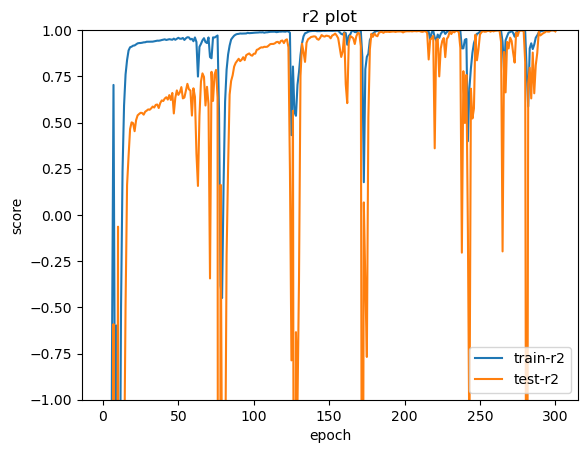

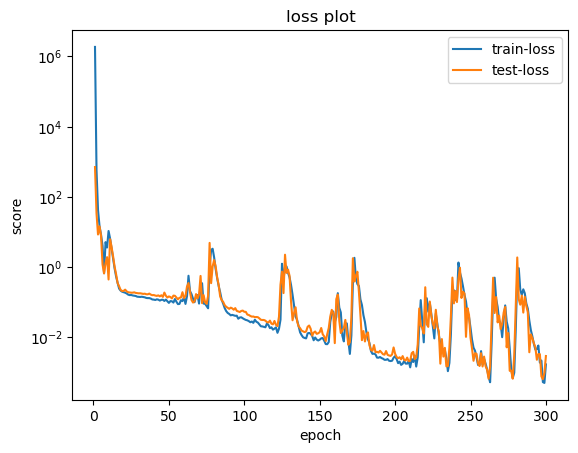

Rank 2 parameter configuration: Unnamed: 0                                      16
number                                          16
value                                     0.863917
datetime_start          2023-12-07 19:30:14.322559
datetime_complete       2023-12-07 19:32:04.896192
duration                    0 days 00:01:50.573633
params_batcher                               False
params_learning_rate                      0.006051
params_n_dim_0                               322.0
params_n_dim_1                               291.0
params_n_dim_2                               137.0
params_n_dim_3                               175.0
params_n_layers                                  5
state                                     COMPLETE
Name: 16, dtype: object
model-parameters: 400145


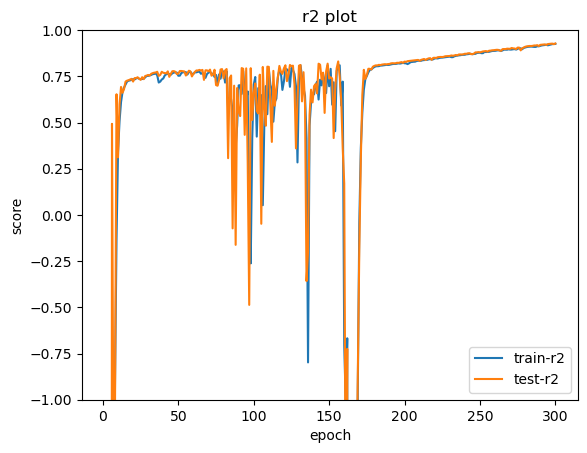

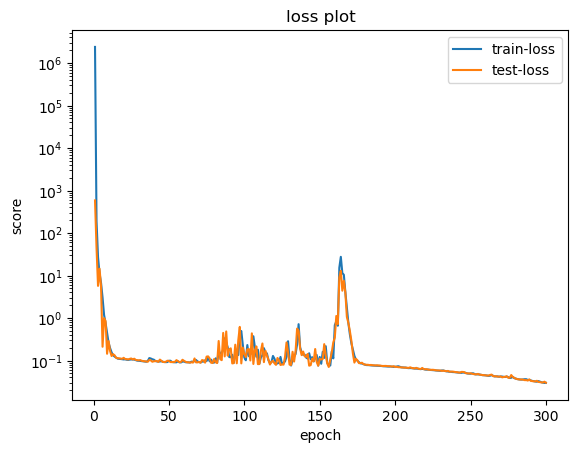

Rank 3 parameter configuration: Unnamed: 0                                      59
number                                          59
value                                      0.84516
datetime_start          2023-12-07 20:39:35.092122
datetime_complete       2023-12-07 20:41:25.457446
duration                    0 days 00:01:50.365324
params_batcher                                True
params_learning_rate                      0.002912
params_n_dim_0                               297.0
params_n_dim_1                                98.0
params_n_dim_2                               296.0
params_n_dim_3                               123.0
params_n_layers                                  5
state                                     COMPLETE
Name: 59, dtype: object
model-parameters: 318210


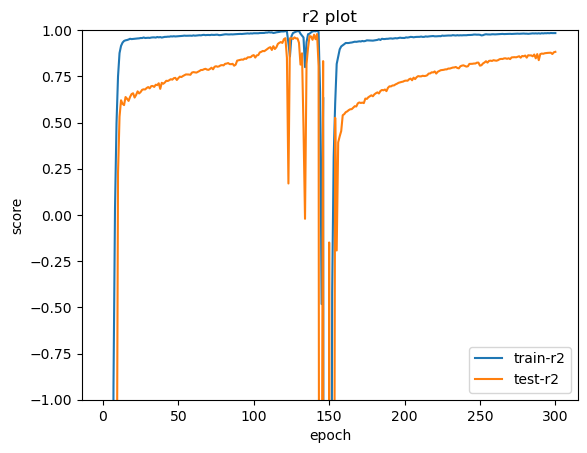

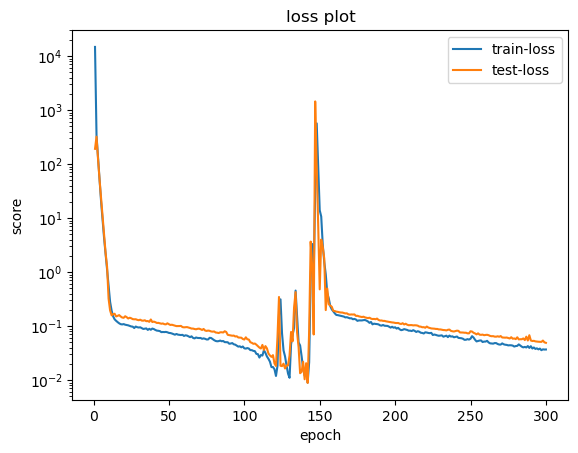

In [5]:
# define label to show
label = "tree_advanced"

# load config storage
config_table = pd.read_csv("study_label-tree-advanced_baseline.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")

## Tree label

Rank 1 parameter configuration: Unnamed: 0                                      47
number                                          47
value                                     0.826578
datetime_start          2023-12-07 22:02:26.293225
datetime_complete       2023-12-07 22:03:44.253593
duration                    0 days 00:01:17.960368
params_batcher                               False
params_learning_rate                      0.007107
params_n_dim_0                               453.0
params_n_dim_1                               222.0
params_n_dim_2                                41.0
params_n_dim_3                               506.0
params_n_layers                                  5
state                                     COMPLETE
Name: 47, dtype: object
model-parameters: 471893


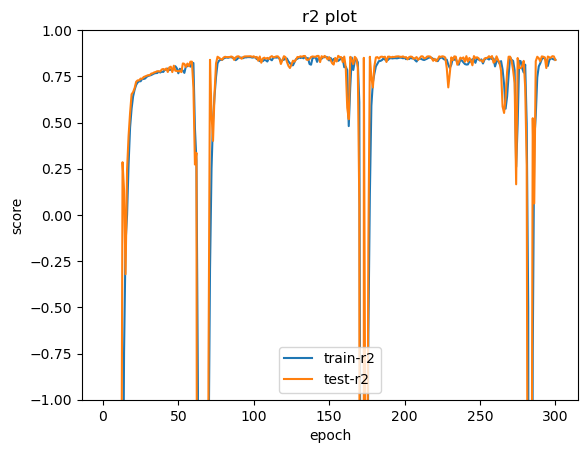

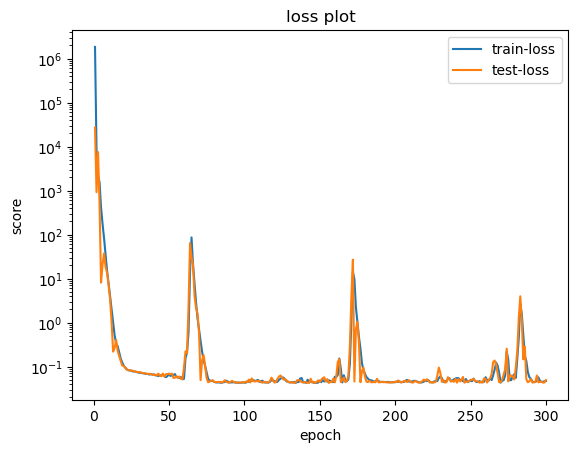

Rank 2 parameter configuration: Unnamed: 0                                      64
number                                          64
value                                     0.812306
datetime_start          2023-12-07 22:29:59.740545
datetime_complete       2023-12-07 22:31:15.632735
duration                    0 days 00:01:15.892190
params_batcher                                True
params_learning_rate                      0.007464
params_n_dim_0                               431.0
params_n_dim_1                               110.0
params_n_dim_2                               109.0
params_n_dim_3                               113.0
params_n_layers                                  5
state                                     COMPLETE
Name: 64, dtype: object
model-parameters: 395844


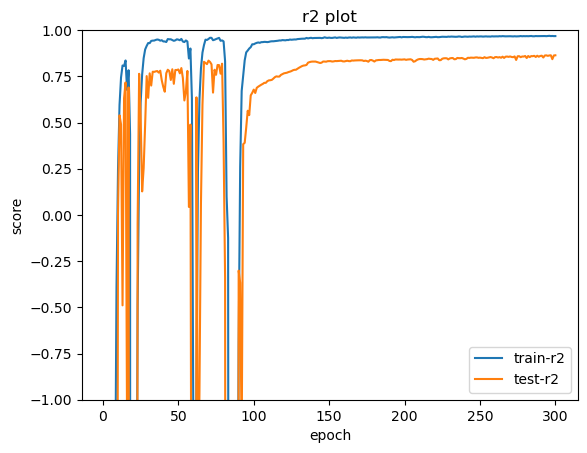

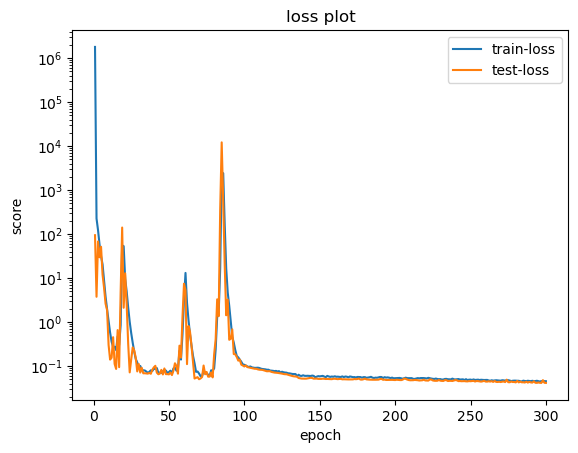

Rank 3 parameter configuration: Unnamed: 0                                      53
number                                          53
value                                      0.77832
datetime_start          2023-12-07 22:15:56.308441
datetime_complete       2023-12-07 22:17:13.810395
duration                    0 days 00:01:17.501954
params_batcher                                True
params_learning_rate                       0.00995
params_n_dim_0                               477.0
params_n_dim_1                               121.0
params_n_dim_2                               221.0
params_n_dim_3                               440.0
params_n_layers                                  5
state                                     COMPLETE
Name: 53, dtype: object
model-parameters: 541148


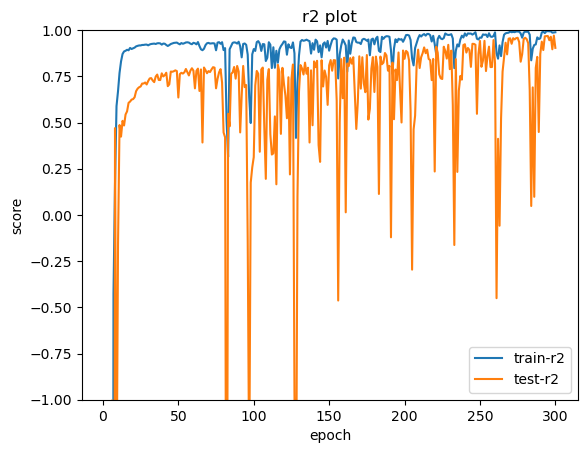

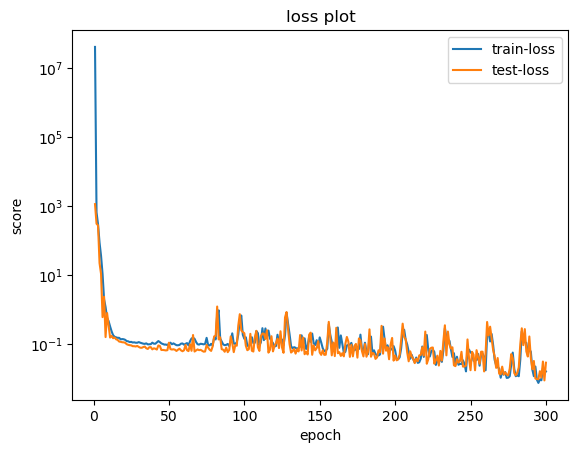

In [6]:
# define label to show
label = "tree"

# load config storage
config_table = pd.read_csv("study_label-tree_baseline.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")

## Default label

Rank 1 parameter configuration: Unnamed: 0                                      32
number                                          32
value                                    -0.241887
datetime_start          2023-12-08 09:02:00.777119
datetime_complete       2023-12-08 09:03:44.356188
duration                    0 days 00:01:43.579069
params_batcher                               False
params_learning_rate                      0.003675
params_n_dim_0                               481.0
params_n_dim_1                               287.0
params_n_dim_2                               336.0
params_n_dim_3                               192.0
params_n_layers                                  5
state                                     COMPLETE
Name: 32, dtype: object
model-parameters: 661230


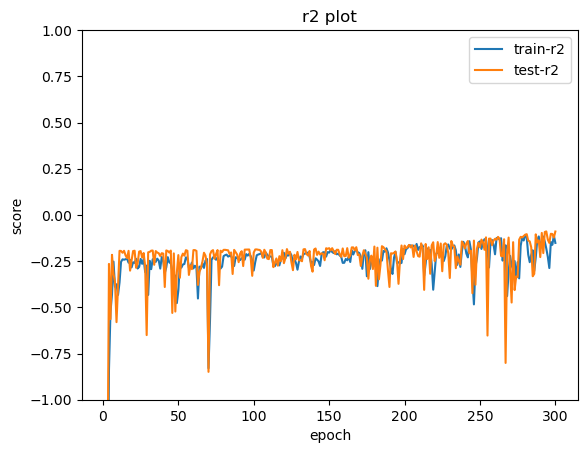

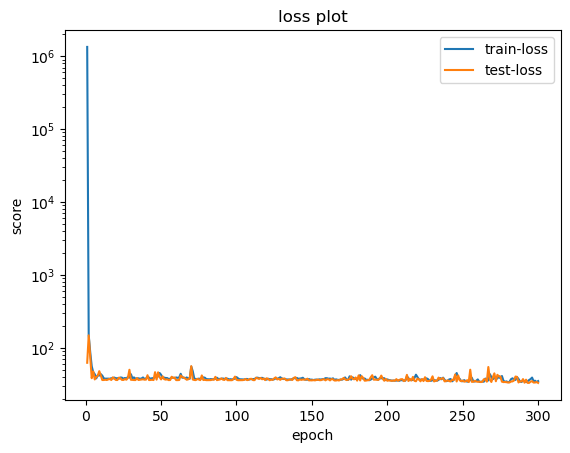

Rank 2 parameter configuration: Unnamed: 0                                      24
number                                          24
value                                    -0.242803
datetime_start          2023-12-08 08:48:10.714087
datetime_complete       2023-12-08 08:49:52.750006
duration                    0 days 00:01:42.035919
params_batcher                               False
params_learning_rate                       0.00347
params_n_dim_0                               459.0
params_n_dim_1                               143.0
params_n_dim_2                               342.0
params_n_dim_3                                 8.0
params_n_layers                                  5
state                                     COMPLETE
Name: 24, dtype: object
model-parameters: 462490


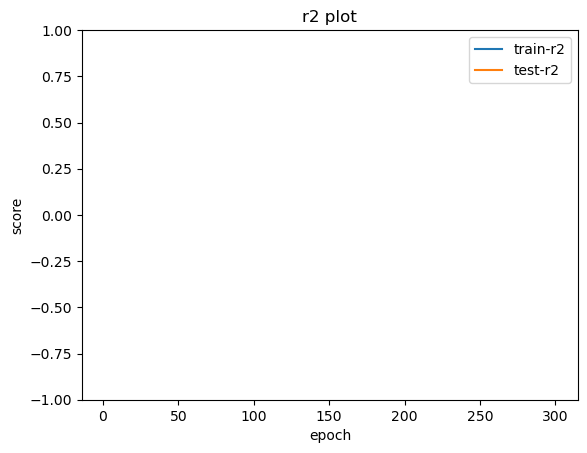

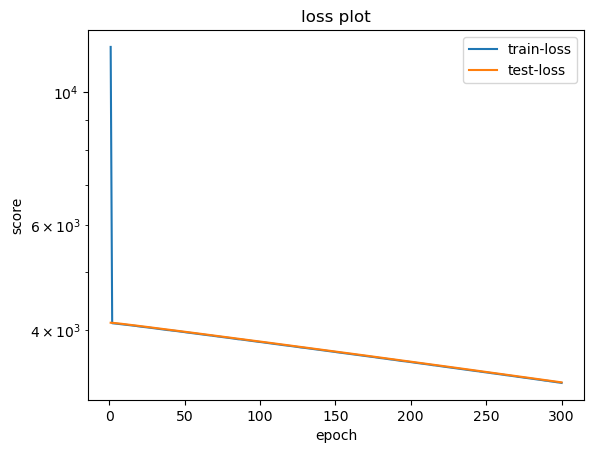

Rank 3 parameter configuration: Unnamed: 0                                      18
number                                          18
value                                     -0.24654
datetime_start          2023-12-08 08:40:32.389233
datetime_complete       2023-12-08 08:41:47.668125
duration                    0 days 00:01:15.278892
params_batcher                               False
params_learning_rate                      0.009285
params_n_dim_0                               455.0
params_n_dim_1                               262.0
params_n_dim_2                               155.0
params_n_dim_3                                 6.0
params_n_layers                                  5
state                                     COMPLETE
Name: 18, dtype: object
model-parameters: 502885


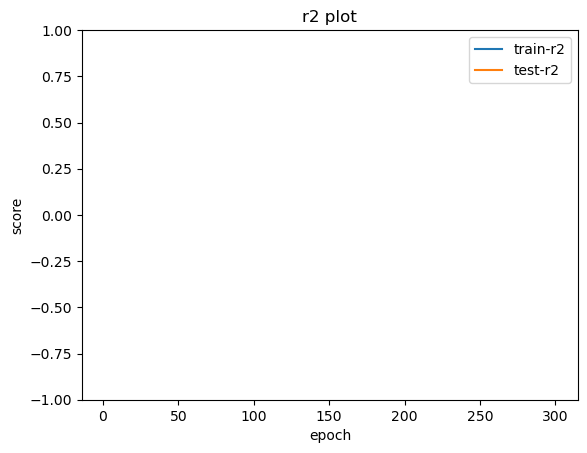

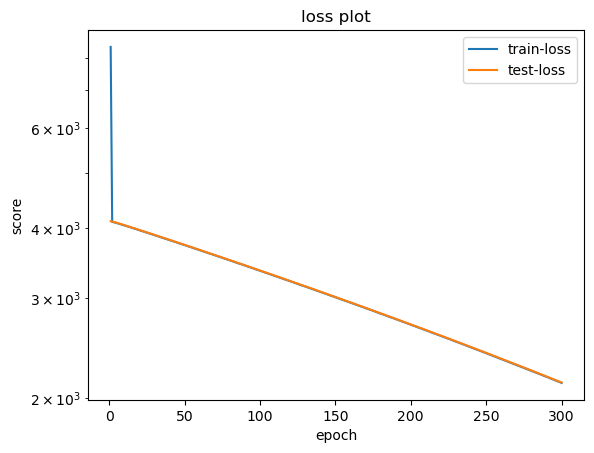

In [7]:
# define label to show
label = "default"

# load config storage
config_table = pd.read_csv("study_label-default_baseline.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")